In [ ]:
'''
Finds all the XY Addition MultipleBond reactions in each model created by David that uses halogen chemistry. 
Compares Ea's of XY Addition MultipleBond and  H_abstraction.
'''

Training reactions from DOI: 10.1021/acs.jpca.9b07029

In [1]:
import cantera as ct
import rmgpy.chemkin
import os
import numpy as np
import matplotlib.pylab as plt
import re
import numpy as np
import collections
%matplotlib inline

# Functions 

In [2]:
def load_chemkin_file(path): 
    """ 
    Load Chemkin file and extract the reactions and species.
    Path should be the path to the species folder.
    """
    
    full_path = os.path.join(path,'chemkin')
    chemkin_path = os.path.join(full_path,'copies', 'copy_chem_annotated.inp')
   # chemkin_path = os.path.join(full_path,'chem_annotated.inp')
    dictionary_path = os.path.join(full_path,'species_dictionary.txt')
    transport_path = os.path.join(full_path,'tran.dat')

    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)

    return species_list, reaction_list


In [4]:
def categorize_reactions(reaction_list):
    """
    Identify H, F-Abstraction reactions and save them to a list. 
    """
 
    #lists for storing data
    H_Abstractions = []
    XY = []

    #identify reactions and save to lists 
    for rxn in reaction_list:
        try: 
            if rxn.family == 'H_Abstraction':
                H_Abstractions.append(rxn)
            if rxn.family == 'XY_Addition_MultipleBond':
                XY.append(rxn)
        except AttributeError: 
            #pass when following error occurs: "AttributeError: 'PDepReaction' object has no attribute 'family' "
             pass
    
    
    return H_Abstractions, XY

    

In [5]:
def generate_Cantera_object(full_path,T,P): 
    """
    Using supplied path, make a Cantera Solution object out of the CTI in this species folder. 
    """
    path_to_cti = os.path.join(full_path,"cantera", "chem_annotated.cti")
    gas = ct.Solution(path_to_cti)
    gas.TP = T, P
    
    return gas
 

In [6]:
def get_reaction_rates(gas, RMG_reactions_of_interest): 
    """
    Use Cantera to get the forward_rates_constants of each reaction.
    Returns a dictionary with key = rmg_reaction, value = [matching Cantera rxn, forward_rate_constant]
    """
    
    #this is a dictionary that will store our data. key = rmg_reaction, value = [matching Cantera rxn, forward_rate_constant]
    rxn_dict = {}
    #list to store rates that will be graphed
    rates = []


    for index, cantera_tuple in enumerate(zip(gas.reactions(), gas.forward_rate_constants)):

        cantera_rxn, rate = cantera_tuple 

        #extract reactants and products from each Cantera reaction and make them sets so we can compare them to other sets
        cantera_reactants = set([reactant for reactant in cantera_rxn.reactants.keys()])
        cantera_products = set([product for product in cantera_rxn.products.keys()])

        #iterate through RMG reactions of interest. For example, these reactions can be the F- of H-Abstraction reactions
        for rxn in RMG_reactions_of_interest:    

            #create empty lists that will store the reactants and products of each RMG reaction of interest.
            RMG_reactants = []
            RMG_products = []

            for reactant in rxn.reactants: 
                RMG_reactants.append(reactant.to_chemkin()) #use "to_chemkin" because we don't want the default smiles label
            for product in rxn.products:
                RMG_products.append(product.to_chemkin())

            #convert the lists to sets 
            rmg_products = set(RMG_products)
            rmg_reactants = set(RMG_reactants)
            
            #compare sets. If the reactants and products of a Cantera reaction and RMG reaction matches, they must be the same reaction. 
            if (cantera_reactants == rmg_reactants) and (cantera_products == rmg_products): 

                #save to dictionary, along with the forward_rate_constant for that reaction. Keep this dictionary in case you want to see if reactions actually match.
                rxn_dict[rxn] = [cantera_rxn, np.log(float(rate))]
                
                #save rates to a separate list
                rates.append(rate)

            else:
                continue

    #make sure we have found matching Cantera rxns for all RMG reactions of interest
    assert len(RMG_reactions_of_interest)==len(rxn_dict.keys())
    
######## get rid of duplicates ##############

    #two lists for storing unduplicated (1) tuples structured as (cantera_rxn, rate), (2) rmg reactions, (3) rates
    list_no_dups = []                 #1
    rmg_reaction_list_no_dups = []    #2
    rate_list_no_dups = []            #3

    #eliminate duplicate reactions by appending the key (rmg_rxn) and value (tuple of (cantera_rxn, rate)) to list #1 
    [list_no_dups.append([k,v]) for k,v in rxn_dict.items() if [k,v] not in list_no_dups]
    
    #extract the RMG reaction for list #1
    for k,v in list_no_dups: 
        rmg_reaction, [cantera_rxn, rate] = k, v
        rmg_reaction_list_no_dups.append(rmg_reaction)
    
    #take the rate from from list #1
        rate_list_no_dups.append(rate)
        

    
    return rate_list_no_dups, rmg_reaction_list_no_dups

In [15]:
def get_Eas_rates(full_path, files_to_exclude, title, T, P):
    '''
    Give full path of the folder (refrigerants, suppressants, etc.), list of files in that destination that are not species folders,
    a title (i.e. "Suppressants"), and temp and pressure. 
    Gets Ea's and rates of H- and F-Abstraction reactions in the species folders. 
    '''
    
    print(title)
    species_folders = [file for file in os.listdir(full_path) if file not in files_to_exclude]
    
    for species in species_folders: 

        try: 
            species_folder_path = os.path.join(full_path, species)
            if os.path.exists(os.path.join(species_folder_path,'chemkin')):
                pass
            else: 
                continue
            species_list, reaction_list = load_chemkin_file(species_folder_path)
            H_Abstractions, XY = categorize_reactions(reaction_list)


            print("*******************************************************************************************************")
            print(species)
            print('\n')
            print(f"Number of XY_Addition_MultipleBond:     {len(XY)} ")
            print(f"Number of H_abstractions:     {len(H_Abstractions)} ")
            print(f"Total reactions:              {len(reaction_list)}")
            print(f"XY percentage out of total reactions: {float((len(XY)/len(reaction_list))*100):.1f} % ")
            print('\n')


            gas = generate_Cantera_object(species_folder_path,298,ct.one_atm)
            H_rates, H_rmg_rxn_list = get_reaction_rates(gas, H_Abstractions)
            XY_rates, XY_rmg_rxn_list = get_reaction_rates(gas, XY)


            #get the activation energies for each reaction type
            H_Ea = np.array([float(rxn.kinetics.Ea.value) for rxn in H_rmg_rxn_list])
            XY_Ea = np.array([float(rxn.kinetics.Ea.value) for rxn in XY_rmg_rxn_list])

            #x axes to plot
            x_XY = list(range(len(XY_Ea)))
            x_H = list(range(len(XY_Ea),len(XY_Ea)+len(H_Ea)))
            
            if len(XY) != 0:
                
                if len(XY) < 10:
                
                #print out the reactions if there aren't a crazy number of them 
                    print('Y_Addition_MultipleBond reactions:')
                    print('\n')
                    for XY_rxn in XY:
                        print(XY_rxn) #print using for loop so your get the equations and not the RMG reaction block text 
                
                #plot the Ea's
                fig, ax1 = plt.subplots()

                ax1.scatter(x_XY, XY_Ea, c='r', label='XY_Addition_MultipleBond')
                ax1.scatter(x_H, H_Ea, c='m', label='H_abstraction')

                #get the forward rate constants for each reaction


                #plot rates 
                ax2 = ax1.twinx()
                ax2.scatter(x_XY, XY_rates, c='b', marker = "v", label='XY_Addition_MultipleBond rate')
                ax2.scatter(x_H, H_rates, c='orange', marker = "v", label='H_abstraction rate')


                plt.xlabel('Reactions')
                ax1.set_ylabel('E_a (kcal/mol)')
                ax2.set_ylabel('Forward Rate Constants: log(K)')
                plt.title(f'Activation energy of XY_Addition_MultipleBond and H-Abstraction reactions in {species} model')
                ax1.legend()
                ax2.legend()
                plt.show()
                
                plt.scatter(XY_Ea, XY_rates, c='r', label='XY_Addition_MultipleBond rate', alpha=0.3 )
                plt.scatter(H_Ea, H_rates, c='b', label='H_abstraction rate', alpha=0.3 )
                plt.xlabel('E_a (kcal/mol)')
                plt.ylabel('Forward Rate Constants: log(K)')
                plt.title(f'XY_Addition_MultipleBond and H-Abstraction reactions in {species} model')
                plt.legend()
                plt.show()
                
            else: 
                continue
        
        except: 
            continue #i know this is very dangerous, but i dont care


            


# Execute

Iterate over all Halogen Species created by David 

In [8]:
T = 1000 #K
P = ct.one_atm

## Suppressants 

Suppressants
*******************************************************************************************************
2-BTP


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     332 
Total reactions:              2251
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
C3F7H


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     154 
Total reactions:              1216
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
CF2BrCHCH2


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     45 
Total reactions:              1010
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
CF2ClBr


Number of XY_Addition_MultipleBond:     0 
Number of 

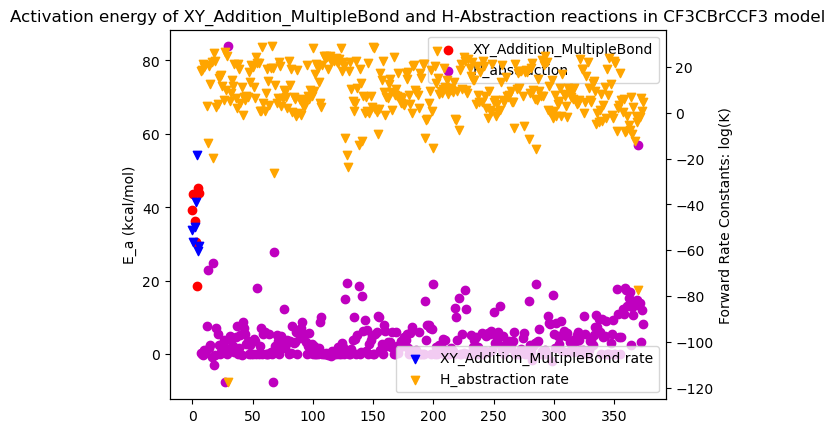

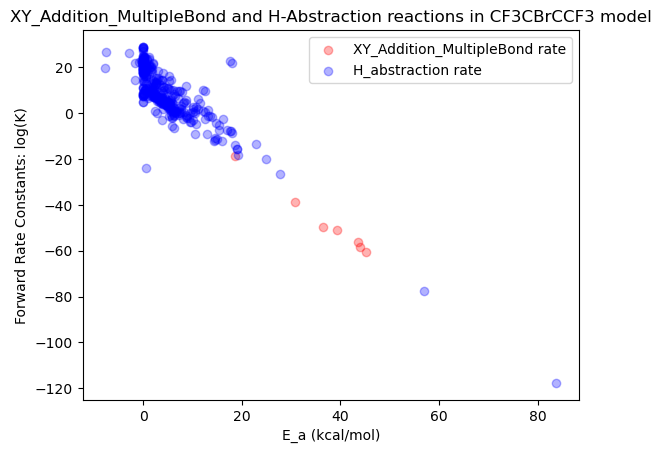

*******************************************************************************************************
CF3CBrCF2


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     201 
Total reactions:              2021
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
CF3CBrCHF


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     313 
Total reactions:              2968
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
CF3CHCl2


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     208 
Total reactions:              1699
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
CF3H


Number of XY_Addition_MultipleBond:     0 
Number of H_abstrac

In [16]:
full_path = '/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/F_abs/DF_models/rmg_combustion_paper_FFCM/suppressants'
files_to_exclude = ['halomethanes']
get_Eas_rates(full_path, files_to_exclude, "Suppressants", T, P)

- CF3CBrCCF3 has a toleranceMovetoCore, toleranceInterruptSimulation = 0.1
- Rest of suppressants have toleranceMovetoCore, toleranceInterruptSimulation ranging from 0.1 - 0.25

## Refrigerants 

Refrigerants
*******************************************************************************************************
C2H5F


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     503 
Total reactions:              4409
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
C2HF5


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     48 
Total reactions:              799
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
C3F7H


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     52 
Total reactions:              1544
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
CF3CH2F


Number of XY_Addition_MultipleBond:     0 
Number of H_abstr

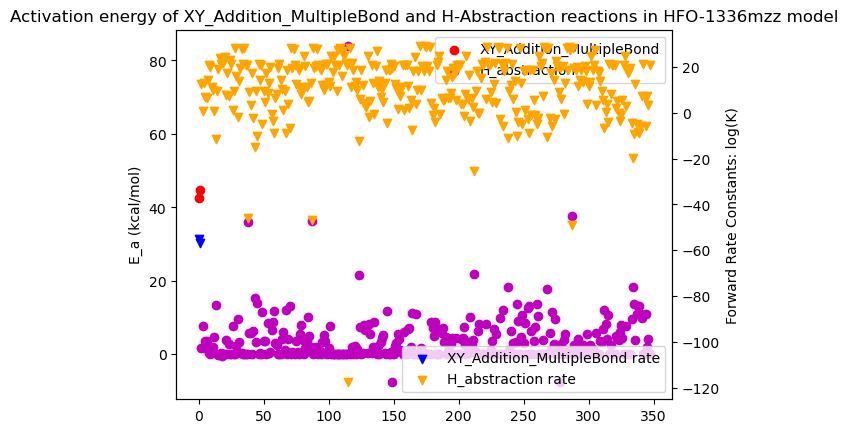

*******************************************************************************************************
R1234ze(E)


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     266 
Total reactions:              2897
XY percentage out of total reactions: 0.0 % 


*******************************************************************************************************
R471A


Number of XY_Addition_MultipleBond:     0 
Number of H_abstractions:     115 
Total reactions:              1743
XY percentage out of total reactions: 0.0 % 




In [10]:
#user defined variables
full_path = '/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/F_abs/DF_models/rmg_combustion_paper_FFCM/refrigerants'
files_to_exclude = ['blend']
get_Eas_rates(full_path, files_to_exclude, "Refrigerants", T, P)
